In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import os

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
!unzip /content/drive/MyDrive/archive.zip -d /content

Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/Final Dataset/testing/Empty/00a2d16e-742e-469f-a23a-631ad49ec790.jpg  
  inflating: /content/Final Dataset/testing/Empty/01d0f221-a94d-44ce-ba07-462f2f46f62c.jpg  
  inflating: /content/Final Dataset/testing/Empty/02bbbe52-297c-4eed-aac2-de40ad6bd0b8.jpg  
  inflating: /content/Final Dataset/testing/Empty/0a175e12-bade-49c4-ad00-c07329ce5fd4.jpg  
  inflating: /content/Final Dataset/testing/Empty/0a37454f-40c2-4302-9e8b-23af7b95875b.jpg  
  inflating: /content/Final Dataset/testing/Empty/0a7b874b-20dd-4ab2-b2ed-89645e4c20bc.jpg  
  inflating: /content/Final Dataset/testing/Empty/0a86cfa7-7b99-4ce7-8da8-42c51d2eafff.jpg  
  inflating: /content/Final Dataset/testing/Empty/0aad5c2c-a166-416a-9d6d-3e5da232a5ae.jpg  
  inflating: /content/Final Dataset/testing/Empty/0acd3ef9-fa98-4e37-aca9-58e4848e36fd.jpg  
  inflating: /content/Final Dataset/testing/Empty/0b6dc85e-a9ba-4d74-8682-d4dd58587bef.jpg  
  inflating: /content/Fin

In [ ]:
!unzip /content/drive/MyDrive/finetuning_model.pth.zip -d /content

Archive:  /content/drive/MyDrive/finetuning_model.pth.zip
  inflating: /content/finetuning_model.pth  


In [ ]:
def load_rand():
    X=[]
    dir_path='/content/Final Dataset/training'
    for sub_dir in tqdm(os.listdir(dir_path)):
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(224,224))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X

In [ ]:
images_arr=np.array(load_rand())
images_arr.shape

100%|██████████| 5/5 [00:00<00:00, 30.67it/s]


(30, 224, 224, 3)

In [ ]:
train_dir = '/content/Final Dataset/training'
test_dir = '/content/Final Dataset/testing'
# Getting labels of training data
labels = os.listdir('/content/Final Dataset/training')
print("Classes names:")
print(".............")
labels

Classes names:
.............


['Traffic Jam', 'Low', 'High', 'Empty', 'Medium']

In [ ]:
datagen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255,
  preprocessing_function=keras.applications.vgg16.preprocess_input
  )

datagen1 = ImageDataGenerator(
  rescale=1./255,
  preprocessing_function=keras.applications.vgg16.preprocess_input
  )
train_generator = datagen.flow_from_directory(train_dir,
                                       target_size=[224,224],
                                       color_mode='rgb',
                                       class_mode="categorical",
                                       batch_size = 32,
                                       shuffle=True)
validation_generator = datagen1.flow_from_directory(test_dir,
                                       target_size=[224,224],
                                       color_mode='rgb',
                                       class_mode="categorical",
                                       batch_size = 32,
                                       shuffle=True)

Found 3378 images belonging to 5 classes.
Found 320 images belonging to 5 classes.


In [ ]:
train_generator.class_indices

{'Empty': 0, 'High': 1, 'Low': 2, 'Medium': 3, 'Traffic Jam': 4}

In [ ]:
validation_generator.class_indices


{'Empty': 0, 'High': 1, 'Low': 2, 'Medium': 3, 'Traffic Jam': 4}

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    top_model = conv_base.output

    # Add Global Average pooling layer
    top_model = GlobalAveragePooling2D()(top_model)

    # Add output layer
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model for training.
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (224, 224, 3)
n_classes=5

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, fine_tune=0)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
checkpoint_filepath = 'vgg16_model_best_weights.h5'
# Model weights are saved at the end of every epoch, if it's the best seen so far.
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

# EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,mode='min')

vgg_history = vgg_model.fit(train_generator,validation_data=validation_generator,
          steps_per_epoch=train_generator.samples/train_generator.batch_size,
          validation_steps=validation_generator.samples/validation_generator.batch_size,
          epochs=70,callbacks=[checkpoint])

Epoch 1/70
106/105 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.7202
Epoch 1: val_accuracy improved from -inf to 0.75937, saving model to vgg16_model_best_weights.h5
105/105 [==============================] - 42s 393ms/step - loss: 0.7100 - accuracy: 0.7202 - val_loss: 0.6427 - val_accuracy: 0.7594
Epoch 2/70
106/105 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.7220
Epoch 2: val_accuracy did not improve from 0.75937
105/105 [==============================] - 41s 389ms/step - loss: 0.7013 - accuracy: 0.7220 - val_loss: 0.6815 - val_accuracy: 0.6938
Epoch 3/70
106/105 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.7265
Epoch 3: val_accuracy did not improve from 0.75937
105/105 [==============================] - 41s 387ms/step - loss: 0.6911 - accuracy: 0.7265 - val_loss: 0.6628 - val_accuracy: 0.7281
Epoch 4/70
106/105 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7238
Epoch 4: val_ac

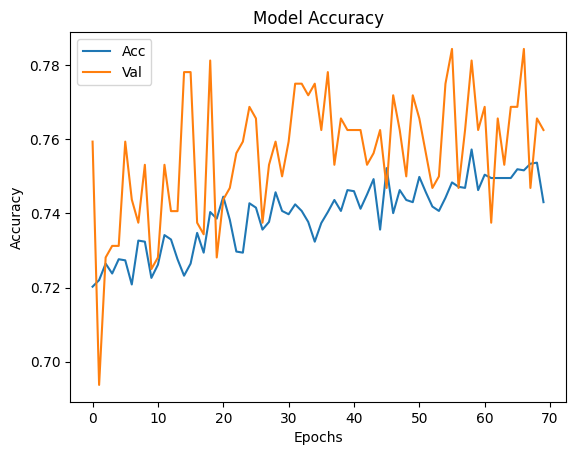

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc','Val'], loc = 'upper left')

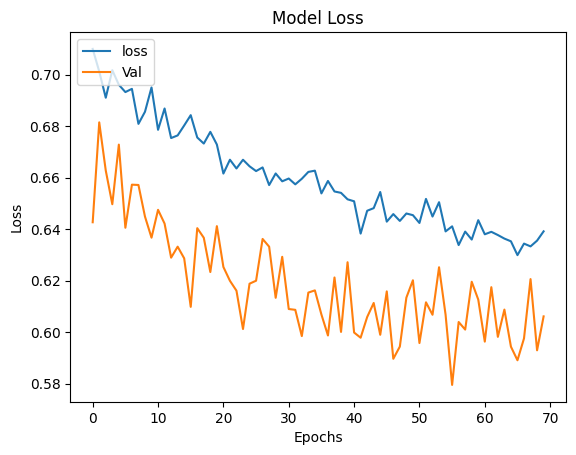

In [ ]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','Val'], loc = 'upper left')

1/1 [==============================] - 0s 145ms/step


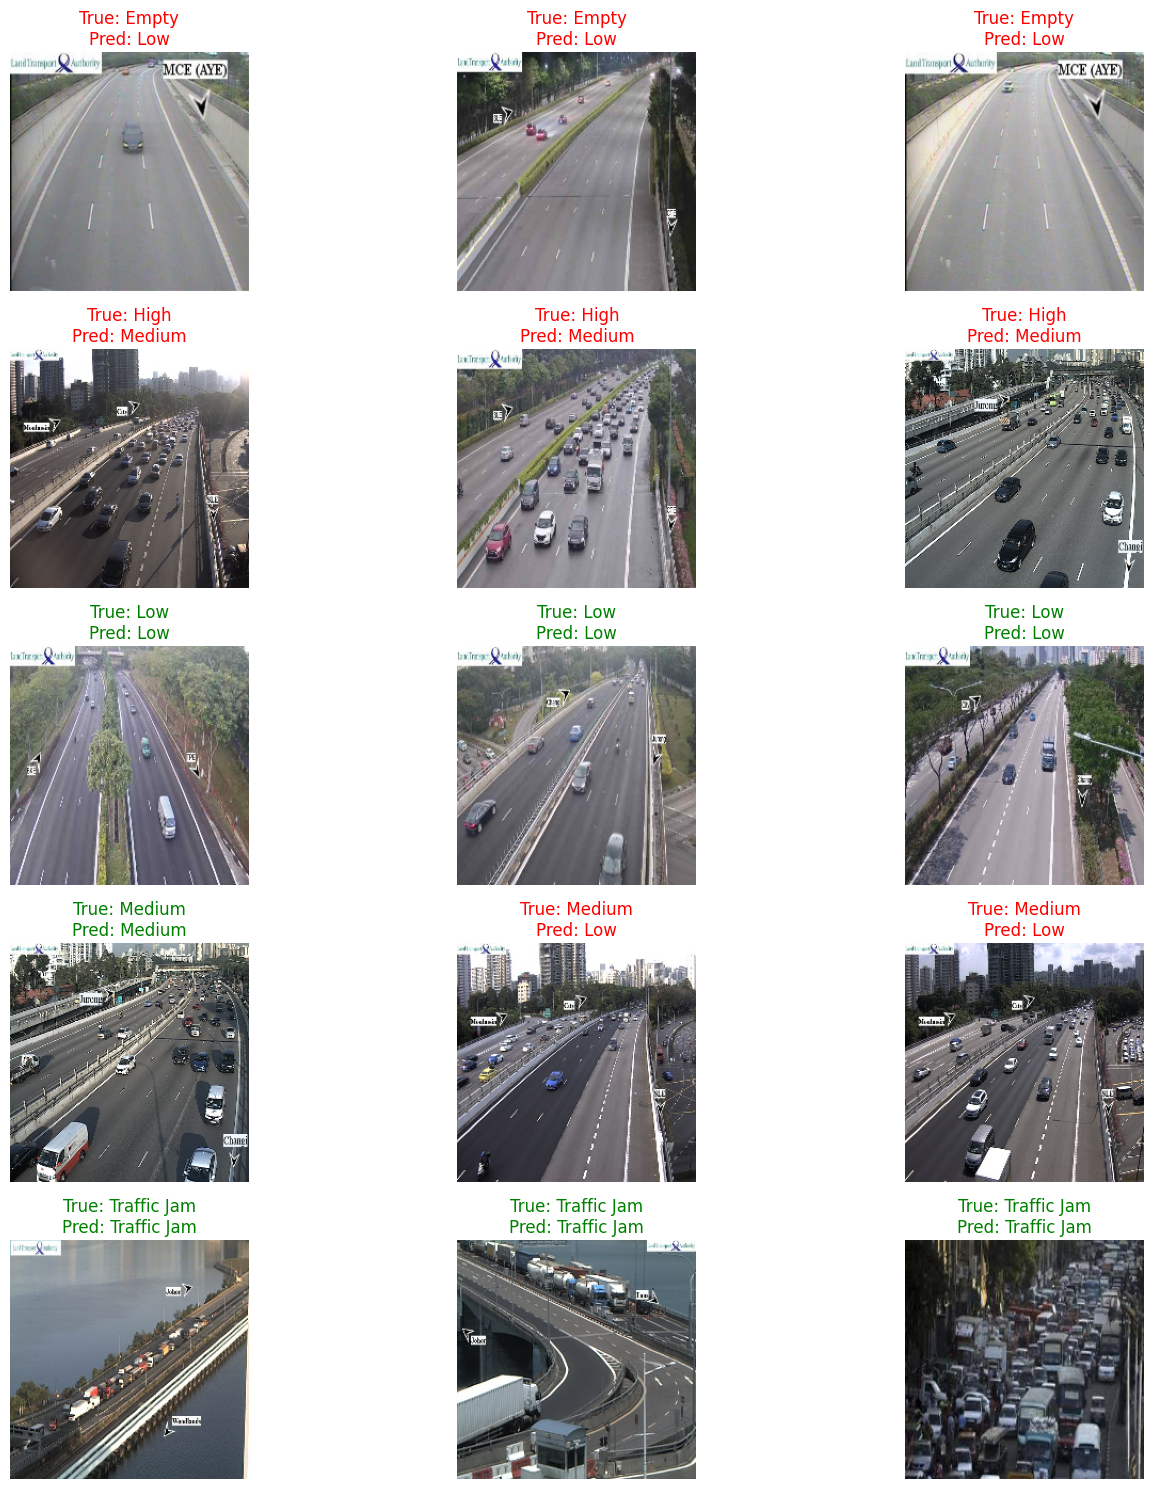

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Define directories and image dimensions
train_dir = '/content/Final Dataset/training'
img_height = 224
img_width = 224

# Function to recreate the model architecture
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    model = Model(inputs=conv_base.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
n_classes = 5

# Recreate the model architecture
vgg_model = create_model(input_shape, n_classes, fine_tune=0)

# Load the model weights
vgg_model.load_weights('vgg16_model_best_weights.h5')

# Load class labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Function to load random images from each class
def load_random_images(directory, class_labels, num_images=5):
    images = []
    labels = []
    for label in class_labels:
        class_dir = os.path.join(directory, label)
        image_files = random.sample(os.listdir(class_dir), num_images)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (img_width, img_height))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load random images from the training directory
images, true_labels = load_random_images(train_dir, class_labels.values(), num_images=3)

# Preprocess images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
images_preprocessed = np.array([datagen.standardize(image) for image in images])

# Make predictions
predictions = vgg_model.predict(images_preprocessed)
predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]

# Display the images with their true and predicted labels
fig, axes = plt.subplots(len(class_labels), 3, figsize=(15, 15))
axes = axes.flatten()

for i, (img, true_label, pred_label) in enumerate(zip(images, true_labels, predicted_labels)):
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color="green" if true_label == pred_label else "red")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
